In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns
import matplotlib.colors as clr
import matplotlib.patches as mpatches
from scipy.stats import f_oneway
import statsmodels.stats.multitest

C:\Users\CRI User\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import matplotlib

# Data import, cleaning and formatting

## Phylogeny and prophages

In [4]:
phylo_all = pd.read_excel('Supp_Table1_Phylogeny.xlsx')
phylo_all.rename(columns = {"topology.1":'topology'}, inplace = True)
##create table filtered to keep only Actinobacteria
phylo = phylo_all.loc[phylo_all.Phylum == 'Actinobacteria'].copy()
phylo.reset_index(inplace = True, drop = True)

In [5]:
Virsorter_results = pd.read_csv('Total_result.tsv', sep ='\t')
Virsorter_results = Virsorter_results[['seqname','trim_bp_start', 'trim_bp_end','seqname_new']]

## Defense systems

In [6]:
df_all = pd.read_excel('Supp_Table2_DefenseGenes.xlsx')
df_all= df_all.merge(phylo_all[list(set(phylo_all.columns)-set(df_all.columns))+['replicon']],on='replicon', how = "left") #merge the columns of phylo_all that are not already present in df


In [7]:
### Getting start (min start position of the genes of the system) and end of each system (max end position of the genes of the system)
sys_min = pd.DataFrame()
a = df_all.groupby('sys_id').start.min()
sys_min['sys_id'] = a.index.to_list()
sys_min['min_pos_sys_bp'] = a.values

sys_max = pd.DataFrame()
c = df_all.groupby('sys_id').end.max()
sys_max['sys_id'] = c.index.to_list()
sys_max['max_pos_sys_bp'] = c.values

positions = sys_min.merge(sys_max, on = 'sys_id')

df_all = df_all.merge(positions, on = 'sys_id')


In [8]:
##create table filtered to keep only Actinobacteria
df = df_all.loc[df_all.Phylum == 'Actinobacteria'].copy()
df.reset_index(inplace = True, drop = True)


### Adding prophage annotation

In [9]:
def is_prophage(x):
    begin_sys = df.loc[x,'start']
    end_sys = df.loc[x,'end']
    replic = df.loc[x,'replicon']
    prophage_id = 'No'
    # If they exist, getting the prophages that encompass each defense genes (same replicon, start before the gene and end after the gene)
    virsorter = Virsorter_results.loc[(Virsorter_results.seqname == replic) 
                                      & (Virsorter_results.trim_bp_start < begin_sys) 
                                      & (Virsorter_results.trim_bp_end > end_sys)]
    if len(virsorter) > 0 :  
        prophage_id = ";".join(virsorter['seqname_new'].to_list())
    
    return(prophage_id) 
   
df['in_prophage'] =  df.index.map(is_prophage)

### Creating tables with one line per system

In [10]:
#For all anti-phage genes
df_all_sys = df_all.drop_duplicates(subset = ['sys_id','ID']).copy()
df_all_sys.reset_index(drop = True, inplace = True)
df_all_sys.drop(columns = ['hit_gene_ref', 'hit_status', 'hit_seq_len', 'hit_i_eval',
       'hit_score', 'hit_profile_cov', 'hit_seq_cov', 'hit_begin_match',
       'hit_end_match', 'start', 'end', 'Strand'], inplace = True)

#For actinobacterial anti-phage genes
df['in_prophage_bis'] = np.where(df.in_prophage != 'No',1,0)
df_sys = df.sort_values('in_prophage_bis', ascending = False).drop_duplicates(subset = ['sys_id','ID']).copy()
df_sys.reset_index(inplace = True, drop = True)

### Adding replicon_type_corrected so plasmids and prophages are mutually exclusive

In [11]:
conditions = [df_sys.in_prophage != 'No',  # A system encoded on a prophage detected on a plasmid will be considered prophage-encoded and not plasmid encoded
            (df_sys.in_prophage == 'No')&(df_sys.replicon_type == 'C'),
            (df_sys.in_prophage == 'No')&(df_sys.replicon_type == 'P')]
values = ['Phage','Chromosome','Plasmid']
df_sys['replicon_type_corrected'] = np.select(conditions,values)

### Adding spatial position annotation on Streptomyces linear chromosomes

In [12]:
## Creating new columns with normalised start and end of the system
df_sys['start_normalised'] = df_sys.min_pos_sys_bp/df_sys.replicon_size
df_sys['end_normalised'] = df_sys.max_pos_sys_bp/df_sys.replicon_size

## Adding categorial variable to describe the position of the system on the chromosome : extremities or central region

limit_extrem = 0.1 #Threshold to define what is considered as the extremities (here first and mast 10% of the chromosome)

conditions = [((df_sys.replicon_type == 'C') & (df_sys.topology == 'linear') & ((df_sys.end_normalised < limit_extrem) | (df_sys.start_normalised > 1-limit_extrem))),
             ((df_sys.replicon_type == 'C') & (df_sys.topology == 'linear')& ((df_sys.end_normalised >= limit_extrem) | (df_sys.start_normalised <= 1-limit_extrem)))] 
vals = ['extremities','middle']
df_sys['position_chr'] = np.select(conditions, vals, default=np.nan)

In [13]:
## Selecting only Streptomyces linear chromosomes
df_strep_select = df_sys.loc[(df_sys.Genus == 'Streptomyces')&(df_sys.replicon_type == 'C')&(df_sys.topology == 'linear')].copy()

## Creating a table containing only systems with more than 45 occurrences in Streptomyces linear chromosomes
system_ok_strep = df_strep_select.groupby('System').size().to_frame(name = 'count').reset_index()
system_ok_strep = system_ok_strep.loc[system_ok_strep['count'] > 45]['System'].to_list()

##  Biosynthetic Gene Clusters

In [14]:
antismash = pd.read_excel('Supp_Table3_BGCs.xlsx')

## Adding a unique index by BGC 
antismash.reset_index(inplace = True)
antismash['index'] = antismash['index'].astype(str)
antismash['BGC_index'] = antismash['Region'] +'_'+ antismash['BGC_type'] + '_' + antismash['index']
antismash.drop(columns= ['index'], inplace = True)

## adding phylogeny
antismash = antismash.merge(phylo_all[['replicon','Phylum','Genus','Species','replicon_type','replicon_size','topology']], on = 'replicon', how = 'left')


### Adding prophage annotation to BGCs, with proportion included

In [15]:
## Checking if each actinobacterial BGC region is fully or partially included within one of the prophages detected by Virsorter
def is_prophage_BGCs(x):
    begin = antismash.loc[x,'start']
    end = antismash.loc[x,'end']
    replic = antismash.loc[x,'replicon']
    prophage_id = 'No'
    fully_included = Virsorter_results.loc[(Virsorter_results.seqname == replic)& #considering only prophages on the same replicon as the BGC
                                           ((Virsorter_results.trim_bp_start < begin)&(Virsorter_results.trim_bp_end > end))] # BGC regions that start and end within a prophage are considered fully included in a prophage
    partially_included = Virsorter_results.loc[(Virsorter_results.seqname == replic)&
                                               ((Virsorter_results.trim_bp_start.between(begin,end))|(Virsorter_results.trim_bp_end.between(begin,end)))] # BGC regions that start or end within a prophage are considered partially included
    if len(fully_included)>0:
        prophage_id = '_'.join(fully_included['seqname_new'].to_list() + ['FULL_BGC'])                              
    elif len(partially_included)>0:
        prophage_id = '_'.join(partially_included['seqname_new'].to_list() + ['partial_BGC'])                                    
    return(prophage_id) 
             
antismash['in_prophage'] =  antismash.index.map(is_prophage_BGCs)


In [16]:
# adding the id of the prophage (seqname_new in the Virsorter tablz) for each BGC fully or partially included in a prophage
def get_prophage_id(x):
    if '_partial_BGC' in x :
        return(x.split('_partial_BGC')[0])
    if '_FULL_BGC' in x :
        return(x.split('_FULL_BGC')[0])
    
antismash['prophage_id'] = antismash['in_prophage'].map(get_prophage_id) 
## For BGCs encoded in a prophage, adding the information on the prophage
antismash = antismash.merge(Virsorter_results, left_on = 'prophage_id', right_on = 'seqname_new', how = 'left') 

In [17]:
## Adding the proportion of each BGC region that is included within a prophage
## Getting the length of the overlap of the BGC region and the prophage

def overlap_BGC_prophage(x):
    if antismash.loc[x,'in_prophage']!= 'No':
        begin_BGC = antismash.loc[x,'start']
        end_BGC = antismash.loc[x,'end']
        begin_phage = antismash.loc[x,'trim_bp_start']
        end_phage = antismash.loc[x,'trim_bp_end']
        start_overlap = max(begin_BGC,begin_phage)
        end_overlap = min(end_BGC,end_phage)
        return(end_overlap - start_overlap)
    else :
        return(0)
    
antismash['length_superposition'] = antismash.index.map(overlap_BGC_prophage)         
antismash['prop_bgc_phage_overlay'] = antismash['length_superposition']/(antismash['end']-antismash['start'])

## Adding the annotations, making prophage and plasmid mutually exclusive
conditions = [antismash.prop_bgc_phage_overlay >= 0.5,
            (antismash.prop_bgc_phage_overlay < 0.5)&(antismash.replicon_type == 'C'),
            (antismash.prop_bgc_phage_overlay < 0.5)&(antismash.replicon_type == 'P')]
values = ['phage','chromosome','plasmid']
antismash['replicon_type_corrected'] = np.select(conditions,values, default=np.nan)

### Adding Spatial annotation to BGCs 

In [18]:
## Adding categorical variable to describe the position of BGC regions on chromosomes
antismash['start_normalised'] = antismash.start/antismash.replicon_size
antismash['end_normalised'] = antismash.end/antismash.replicon_size

conditions = [((antismash.replicon_type == 'C') & (antismash.topology == 'linear') & ((antismash.end_normalised < limit_extrem) | (antismash.start_normalised > 1-limit_extrem))),
             ((antismash.replicon_type == 'C') & (antismash.topology == 'linear')& ((antismash.end_normalised >= limit_extrem) | (antismash.start_normalised <= 1-limit_extrem)))] 
vals = ['extremities','middle']
antismash['position_chr'] = np.select(conditions, vals, default=np.nan)

In [19]:
## Filtering to keep only BGCs encoded on Streptomyces linear chromosomes
antismash_strep_select = antismash.loc[(antismash.Genus == "Streptomyces")&(antismash.replicon_type == 'C')&(antismash.topology == 'linear')]
a = antismash_strep_select.groupby('BGC_type').size().to_frame('nb_occurrences')

## Filtering to keep only BGCs types with more than 60 occurrences
BGCs_ok = a.loc[a.nb_occurrences > 60].index.to_list()
antismash_strep_select = antismash_strep_select.loc[antismash_strep_select.BGC_type.isin(BGCs_ok)]

## Sorting the table by alphabetical order of BGC types (ignoring upper and lower case characters)
antismash_strep_select['BGC_type_upper'] = antismash_strep_select['BGC_type'].str.upper()
antismash_strep_select.sort_values('BGC_type_upper', inplace = True)
antismash_strep_select.drop(columns = ["BGC_type_upper"], inplace = True)


## Preparing color palette

In [20]:
palette1 = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']

# Figures

## Figure 1: systems distribution in Actinobacteria

### Figure 1.A : Number of defense systems per genome depending on the actinobacterial genus

Creating a dataframe of average number of systems per actinobacterial genus

In [21]:
a = pd.DataFrame()
b = pd.DataFrame()

## creating a table with the number of genomes per actinobacterial genus
b['Genus'] = phylo.drop_duplicates('ID').groupby('Genus').size().index
b['Nb_genomes'] = phylo.drop_duplicates('ID').groupby('Genus').size().values

## creating a table with the number of systems per actinobacterial genus
a['Genus'] = df_sys.groupby('Genus').size().index
a['Nb_sys'] = df_sys.groupby('Genus').size().values

## Merging the two tables to obtain the average number of system per genome depending on the actinobacterial genus
genus_means = b.merge(a, on = 'Genus', how = 'left')
genus_means['Mean'] = genus_means['Nb_sys']/genus_means['Nb_genomes']

threshold_nb_genomes = 20 
genus_ok = genus_means.loc[genus_means.Nb_genomes > threshold_nb_genomes]['Genus'] # List of genera with more than 20 genomes

Plotting

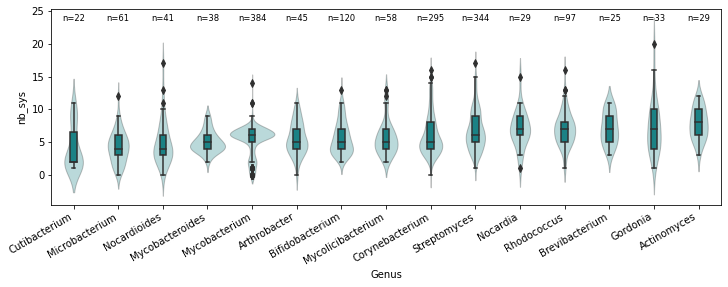

In [22]:
## Creating a table with the number of defense 
a = phylo.drop_duplicates('ID')[['ID','Genus']].copy()
b = pd.DataFrame()
b['ID'] = df_sys.groupby('ID').size().index
b['nb_sys'] = df_sys.groupby('ID').size().values

table_Fig1A = a.merge(b, how ='left', on = 'ID')
table_Fig1A.fillna(0, inplace = True)
table_Fig1A = table_Fig1A.loc[table_Fig1A.Genus.isin(genus_ok)] #Filtering to keep only genera with more than 20 genomes
    
table_Fig1A = table_Fig1A.merge(genus_means[['Genus','Mean']], on = 'Genus', how = 'left') #sort by mean of genus
table_Fig1A.sort_values('Mean', inplace = True)

## Preparing the legends to annotate the graph
legend_genus = genus_means.loc[genus_means.Nb_genomes > threshold_nb_genomes].sort_values('Mean')['Genus']
legend_nb = genus_means.loc[genus_means.Nb_genomes > threshold_nb_genomes].sort_values('Mean')['Nb_genomes']
legend_nb = ['n=' + str(x) for x in legend_nb]

## Plotting
fig,ax = plt.subplots(figsize = (12,4))
sns.violinplot(data= table_Fig1A, x='Genus', y='nb_sys', ax=ax, order = legend_genus, linewidth = 1, inner = None, alpha = [0.2]*len(genus_ok), width = 1, color = palette1[2])
plt.setp(ax.collections, alpha=.3)
sns.boxplot(data= table_Fig1A, x='Genus', y='nb_sys', ax=ax, order = legend_genus, width=0.15, boxprops={'zorder': 2},color = palette1[2])

## Formatting the graph and annotating it with the number of genomes per actinobacterial genome
fig.autofmt_xdate()
pos = range(len(legend_nb))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 23.5, legend_nb[tick], horizontalalignment='center', size='small', color='black') #weight='semibold')

plt.style.use("default")
plt.show()


### Figure 1.B

In [23]:
## Building pivoted dataframe with the number of genomes encoding each type of defense systems per genus of Acinobacteria
df_sys['value'] = 1
piv =pd.pivot_table(df_sys.drop_duplicates(['ID','System']), index = ['System'], columns = ['Genus'], values = 'value', aggfunc = sum).fillna(0)

## Getting the frequency of each type of defense systems per actinobacterial genus
table_freq = pd.DataFrame()
for genus in piv.columns.to_list():
    nb_genus = len(phylo.drop_duplicates('ID').loc[phylo.drop_duplicates('ID').Genus == genus])
    if nb_genus > threshold_nb_genomes : ## Keeping
        table_freq[genus]= piv[genus]/nb_genus
        

## Getting the frequency of each type of defense systems in all Actinobacteria genomes
nb_tot = len(phylo.drop_duplicates('ID'))
a = df_sys.drop_duplicates(['ID','System']).System.value_counts()/nb_tot
a = pd.DataFrame(a)
a.columns = ['All']
table_freq = a.merge(table_freq, how = 'inner', left_index = True, right_index = True )
table_freq.sort_index(inplace = True)

### Sorting defense systems by alphabetical order for plotting :
table_freq['System_before'] = table_freq.index
table_freq['sys_after'] = table_freq['System_before'].str.upper()
table_freq.sort_values('sys_after', inplace = True)
table_freq.drop(columns = ["System_before","sys_after"], inplace = True)


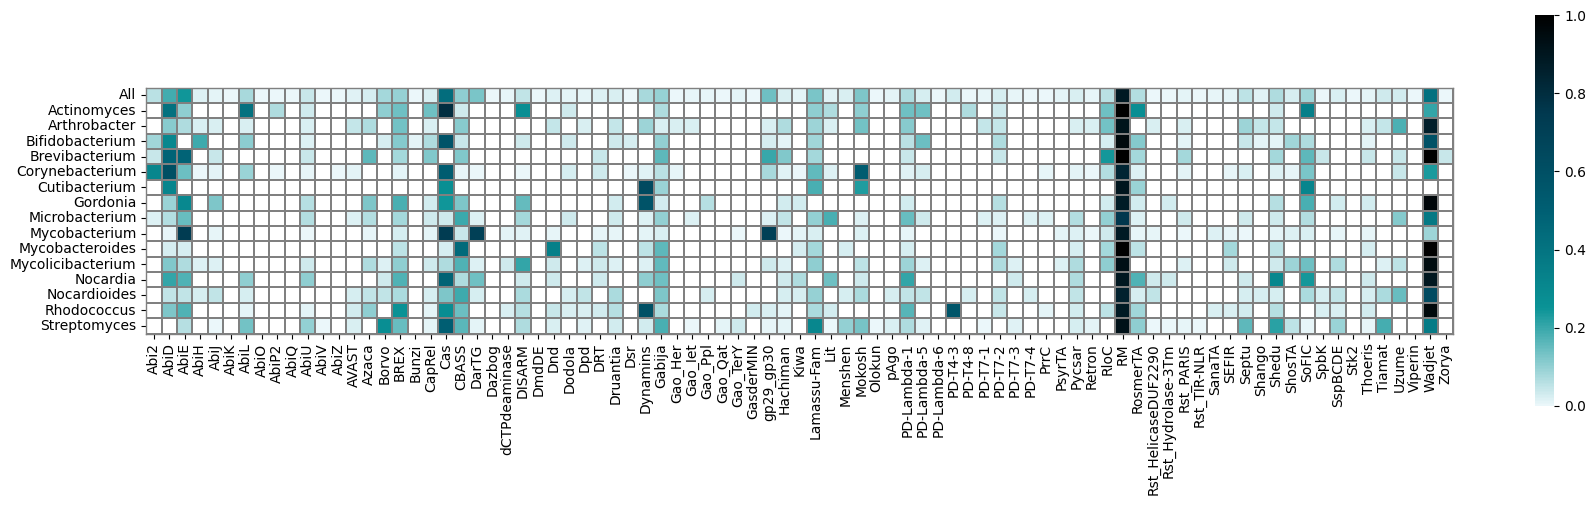

In [24]:
## Plotting
cmap = clr.LinearSegmentedColormap.from_list('custom blue', ['#ebf7fa','#0a9396','#005f73','#01394f','black'], N=256)

table_freq = table_freq.replace(0, np.NaN)
fig, ax = plt.subplots(figsize=(18,5)) 
g = sns.heatmap(table_freq.transpose(), square=True, xticklabels = True, yticklabels = True,
                cmap = cmap, linewidths=0.1, linecolor='grey', vmin=0, vmax=1)
g.set_facecolor('white')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_color('grey')
        
fig.tight_layout()
plt.show()

### Differential abuncance of defense systems in Actinobacteria vs other batceria (Figure 1.D and E)

Computing the estimators of the enrichment of defense systems in Actinobacteria vs other bacteria


In [25]:
# Getting estimators of the differential abundance of defense systems' types in Actinobacteria vs other bacteria

## Building pivoted dataframe with the number of occurrences of each type of defense systems in Actinobacteria vs other bacteria

df_all_sys['actino_or_not'] = np.where(df_all_sys['Phylum'] == 'Actinobacteria','Actinobacteria','All_but_actinobacteria')
df_all_sys['value'] = 1
piv_all_enrich_actino =pd.pivot_table(df_all_sys, index = ['System'], columns = ['actino_or_not'], values = 'value', aggfunc = sum).fillna(0)

#Building the dataframe with average number of occurrences per genome in Actinobacteria vs other bacteria
nb_actino = len(phylo_all.drop_duplicates('ID').loc[phylo_all.drop_duplicates('ID')['Phylum'] == 'Actinobacteria'])
nb_not_actino = len(phylo_all.drop_duplicates('ID').loc[phylo_all.drop_duplicates('ID')['Phylum'] != 'Actinobacteria'])
nb_tot = len(phylo_all.drop_duplicates('ID'))

table_freq_enrich_actino= pd.DataFrame()
table_freq_enrich_actino.index = piv_all_enrich_actino.index
table_freq_enrich_actino['Actinobacteria'] = piv_all_enrich_actino['Actinobacteria'] / nb_actino
table_freq_enrich_actino['All_but_actinobacteria'] = piv_all_enrich_actino['All_but_actinobacteria'] / nb_not_actino

##Adding column with frequence in all (actino or not actino)
a = df_all_sys.System.value_counts()/nb_tot
a = pd.DataFrame(a)
a.columns = ['All']

table_freq_enrich_actino = a.merge(table_freq_enrich_actino, how = 'inner', left_index = True, right_index = True)

##computing estimators :
table_freq_enrich_actino['ratio'] = table_freq_enrich_actino['Actinobacteria']/table_freq_enrich_actino['All_but_actinobacteria']
table_freq_enrich_actino['estimators'] = (table_freq_enrich_actino['Actinobacteria'] - table_freq_enrich_actino['All_but_actinobacteria']) / table_freq_enrich_actino['All']
table_freq_enrich_actino.sort_values('estimators', inplace = True,ascending = False)

Computing the estimators of the enrichment of defense systems in Proteobacteria vs other bacteria

In [26]:
# Getting estimators of the differential abundance of defense systems' types in Proteobacteria vs other bacteria

## Building pivoted dataframe with the number of occurrences of each type of defense systems in Proteobacteria vs other bacteria
df_all_sys['proteo_or_not'] = np.where(df_all_sys['Phylum'] == 'Proteobacteria','Proteobacteria','All_but_Proteobacteria')
df_all_sys['value'] = 1
piv_all_enrich_proteo =pd.pivot_table(df_all_sys, index = ['System'], columns = ['proteo_or_not'], values = 'value', aggfunc = sum).fillna(0)

#Building the dataframe with average number of occurrences per genome in Proteobacteria vs other bacteria
nb_proteo = len(phylo_all.drop_duplicates('ID').loc[phylo_all.drop_duplicates('ID')['Phylum'] == 'Proteobacteria'])
nb_not_proteo = len(phylo_all.drop_duplicates('ID').loc[phylo_all.drop_duplicates('ID')['Phylum'] != 'Proteobacteria'])
nb_tot = len(phylo_all.drop_duplicates('ID'))

table_freq_enrich_proteo = pd.DataFrame()
table_freq_enrich_proteo.index = piv_all_enrich_proteo.index
table_freq_enrich_proteo['Proteobacteria'] = piv_all_enrich_proteo['Proteobacteria'] / nb_proteo
table_freq_enrich_proteo['All_but_Proteobacteria'] = piv_all_enrich_proteo['All_but_Proteobacteria'] / nb_not_proteo

##Adding column with frequence in all (Proteobacteria or not)
a = df_all_sys.System.value_counts()/nb_tot
a = pd.DataFrame(a)
a.columns = ['All']

table_freq_enrich_proteo = a.merge(table_freq_enrich_proteo, how = 'inner', left_index = True, right_index = True)

##computing estimators :
table_freq_enrich_proteo['ratio'] = table_freq_enrich_proteo['Proteobacteria']/table_freq_enrich_proteo['All_but_Proteobacteria']
table_freq_enrich_proteo['estimators'] = (table_freq_enrich_proteo['Proteobacteria'] - table_freq_enrich_proteo['All_but_Proteobacteria']) / table_freq_enrich_proteo['All']
table_freq_enrich_proteo.sort_values('estimators', inplace = True,ascending = False)

Getting number of occurrences of each type of anti-phage system per genome

In [27]:
## Number of occurrences of each type of anti-phage systems per genome containing at least one defense system (will be used to compute ANOVA tests)
a = df_all_sys[['ID','System','value']].groupby(['ID','System']).count()
a.reset_index(inplace = True)
b = pd.pivot_table(a, index = ['ID'], columns = ['System'], values = 'value').fillna(0) ##Pivot systems to columns

## adding organisms without defense systems:
c = pd.DataFrame(columns = b.columns,
                 index = phylo_all.loc[~phylo_all['ID'].isin(df_all_sys.ID)].drop_duplicates('ID').ID )
c = c.fillna(0)

## Concatenating the two table to obtain the Number of each type of anti-phage systems per genome
Count_sys_per_genome = pd.concat([b,c]).copy()
Count_sys_per_genome = Count_sys_per_genome.merge(phylo_all.drop_duplicates('ID')[['ID','Phylum']],on ='ID')

Liste_systems = df_all_sys.System.unique()


ANOVA test on the mean number of occurrences of each type of anti-phage system in Actinobacteria vs other bacteria

In [28]:
## Creating a table of p Values (ANOVA) for Actinobacteria
Sys_pvalues_actino = pd.DataFrame(index = Liste_systems, columns = ['ANOVA_pvalue'])
for sys in Liste_systems:
    actino = Count_sys_per_genome.loc[Count_sys_per_genome.Phylum == 'Actinobacteria'][sys]
    not_actino = Count_sys_per_genome.loc[Count_sys_per_genome.Phylum != 'Actinobacteria'][sys]
    f,p = f_oneway(actino, not_actino)
    Sys_pvalues_actino.loc[sys,'ANOVA_pvalue'] = p
    
## Correction by multiple test
(areSignificant, correctedPvalues, _, _) = statsmodels.stats.multitest.multipletests(Sys_pvalues_actino.ANOVA_pvalue, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
Sys_pvalues_actino['pvalue_corrected'] = correctedPvalues

## Creating corrected annotation : 
conditions2 = [Sys_pvalues_actino.pvalue_corrected > 0.05,
               Sys_pvalues_actino.pvalue_corrected <= 0.05]
significance2 = [ "not", "significant" ]   
Sys_pvalues_actino["significance_corrected"] = np.select(conditions2, significance2, default=np.nan)

## merging with table_freq
table_freq_enrich_actino = table_freq_enrich_actino.merge(Sys_pvalues_actino, left_index=True, right_index=True)


###Adding color coding corrected
conditions2 = [table_freq_enrich_actino.significance_corrected == 'not',
              (table_freq_enrich_actino.significance_corrected == 'significant')&(table_freq_enrich_actino.ratio > 1),
              (table_freq_enrich_actino.significance_corrected == 'significant')&(table_freq_enrich_actino.ratio < 1)
               ]
significance2 = ['lightgrey', palette1[6], palette1[1] ]

table_freq_enrich_actino["color_corrected"] = np.select(conditions2, significance2, default='black')

## filter to remove systems completely absent from the phylum
table_freq_enrich_actino_filtered = table_freq_enrich_actino.loc[table_freq_enrich_actino.Actinobacteria > 0] ## filtered to remove systems absent from bacteria


ANOVA test on the mean number of occurrences of each type of anti-phage system in Proteobacteria vs other bacteria

In [29]:
## Creating a table of p Values (ANOVA) for Proteobacteria
Sys_pvalues_proteo = pd.DataFrame(index = Liste_systems, columns = ['ANOVA_pvalue'])
for sys in Liste_systems:
    proteo = Count_sys_per_genome.loc[Count_sys_per_genome.Phylum == 'Proteobacteria'][sys]
    not_proteo = Count_sys_per_genome.loc[Count_sys_per_genome.Phylum != 'Proteobacteria'][sys]
    f,p = f_oneway(proteo, not_proteo)
    Sys_pvalues_proteo.loc[sys,'ANOVA_pvalue'] = p
    
## Correction by multiple test
(areSignificant, correctedPvalues, _, _) = statsmodels.stats.multitest.multipletests(Sys_pvalues_proteo.ANOVA_pvalue, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
Sys_pvalues_proteo['pvalue_corrected'] = correctedPvalues

## Creating corrected annotation : 
conditions2 = [Sys_pvalues_proteo.pvalue_corrected > 0.05,
               Sys_pvalues_proteo.pvalue_corrected <= 0.05]
significance2 = [ "not", "significant" ]   
Sys_pvalues_proteo["significance_corrected"] = np.select(conditions2, significance2, default=np.nan)

## merging with table_freq
table_freq_enrich_proteo = table_freq_enrich_proteo.merge(Sys_pvalues_proteo, left_index=True, right_index=True)


###Adding color coding corrected
conditions2 = [table_freq_enrich_proteo.significance_corrected == 'not',
              (table_freq_enrich_proteo.significance_corrected == 'significant')&(table_freq_enrich_proteo.ratio > 1),
              (table_freq_enrich_proteo.significance_corrected == 'significant')&(table_freq_enrich_proteo.ratio < 1)
               ]
significance2 = ['lightgrey', palette1[6], palette1[1] ]

table_freq_enrich_proteo["color_corrected"] = np.select(conditions2, significance2, default='black')

## filter to remove systems completely absent from the phylum
table_freq_enrich_proteo_filtered = table_freq_enrich_proteo.loc[table_freq_enrich_proteo.Proteobacteria > 0] ## filtered to remove systems absent from bacteria


Figure 1.E 

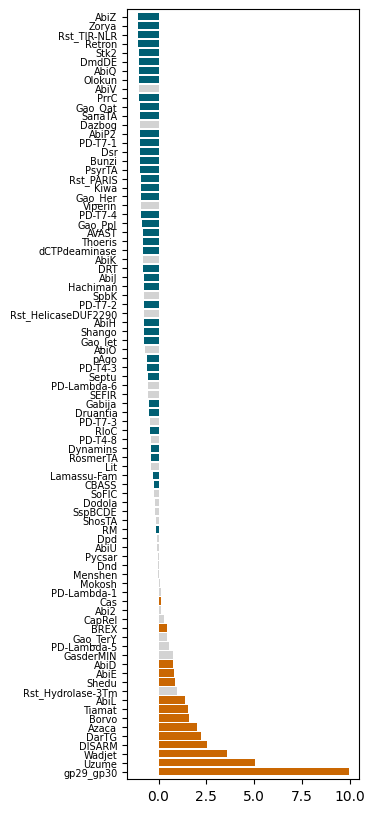

In [30]:
# Barplot estimators by system, color depending on significance of the ANOVA test
fig,ax = plt.subplots(figsize = (3,10))
height = table_freq_enrich_actino_filtered['estimators']
bars = table_freq_enrich_actino_filtered.index.to_list()
y_pos = np.arange(len(bars))
color_corrected = table_freq_enrich_actino_filtered.color_corrected
 
# Create horizontal bars and formatting
ax.barh(y_pos, height, color = color_corrected)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels = bars, size = 7)
ax.autoscale(enable=None, axis="x", tight=True)
ax.margins(0.05, 0.005)


Figure 1.D 

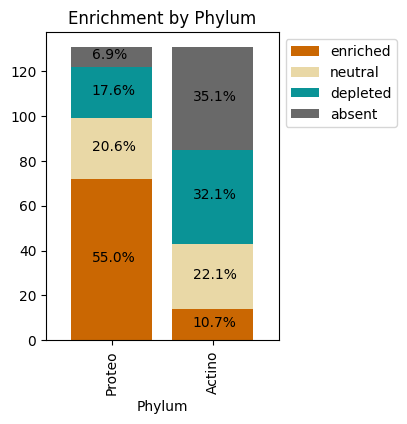

In [31]:
## Plotting the number of defense systems that are absent or enriched/depleted for Actinobacteria vs others and for Proteobacteria vs others  
enriched_acti = len(table_freq_enrich_actino_filtered.loc[(table_freq_enrich_actino_filtered.estimators >0) & (table_freq_enrich_actino_filtered.significance_corrected != 'not')])
depleted_acti = len(table_freq_enrich_actino_filtered.loc[(table_freq_enrich_actino_filtered.estimators <0) & (table_freq_enrich_actino_filtered.significance_corrected != 'not')])
neutral_acti = len(table_freq_enrich_actino_filtered.loc[(table_freq_enrich_actino_filtered.significance_corrected == 'not')])
absent_acti = len(set(df_all_sys.System) - set(df_all_sys.loc[df_all_sys.Phylum == 'Actinobacteria'].System))

enriched_proteo = len(table_freq_enrich_proteo_filtered.loc[(table_freq_enrich_proteo_filtered.estimators >0) & (table_freq_enrich_proteo_filtered.significance_corrected != 'not')])
depleted_proteo = len(table_freq_enrich_proteo_filtered.loc[(table_freq_enrich_proteo_filtered.estimators <0) & (table_freq_enrich_proteo_filtered.significance_corrected != 'not')])
neutral_proteo = len(table_freq_enrich_proteo_filtered.loc[(table_freq_enrich_proteo_filtered.significance_corrected == 'not')])
absent_proteo = len(set(df_all_sys.System) - set(df_all_sys.loc[df_all_sys.Phylum == 'Proteobacteria'].System))

## values to use for the B


fig,ax = plt.subplots(figsize=(3,4))
enrichment = pd.DataFrame([['Proteo', enriched_proteo, neutral_proteo, depleted_proteo, absent_proteo], ['Actino', enriched_acti, neutral_acti, depleted_acti, absent_acti]],
                       columns=['Phylum','enriched', 'neutral', 'depleted',  'absent'])
enrichment.plot(x='Phylum', kind='bar', stacked=True, title='Enrichment by Phylum', color = [palette1[6],palette1[4],palette1[2],'dimgrey'], ax = ax, width = 0.8)


heigth = -1
for i in [enriched_proteo, neutral_proteo, depleted_proteo, absent_proteo]:
    ax.text(-0.2, heigth+i/2, str(round(100*i/131,1))+'%')
    heigth += i
    
heigth = -1
for i in [enriched_acti, neutral_acti, depleted_acti, absent_acti]:
    ax.text(0.8, heigth+i/2, str(round(100*i/131,1))+'%')
    heigth += i

ax.legend(bbox_to_anchor=(1, 1))


### Figure 1.C

<AxesSubplot: xlabel='System'>

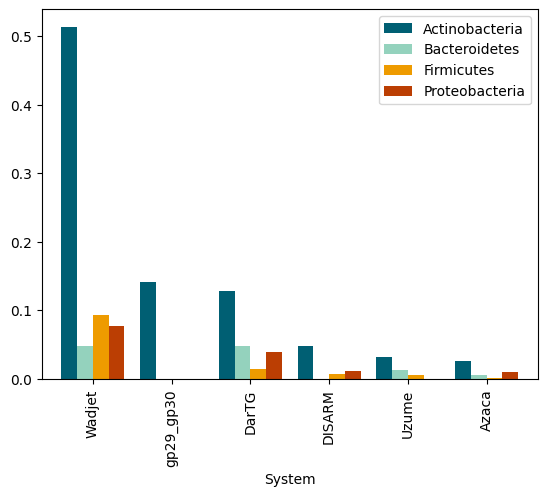

In [32]:
df_all_sys['value'] = 1
piv_all_phyla =pd.pivot_table(df_all_sys, index = ['System'], columns = ['Phylum'], values = 'value', aggfunc = sum).fillna(0)

table_freq_all_phyla = pd.DataFrame()

for phylum in piv_all_phyla.columns.to_list():
    nb_phylum = len(phylo_all.drop_duplicates('ID').loc[phylo_all.drop_duplicates('ID').Phylum == phylum])
    if nb_phylum > 500 : #Keeping only phyla with more than 500 genomes
        table_freq_all_phyla[phylum]= piv_all_phyla[phylum]/nb_phylum
        
table_freq_all_phyla.sort_values('Actinobacteria', inplace = True, ascending=False)

## Keeping only the systems enriched ++ in Actinobacteria:
enriched_systems = table_freq_enrich_actino_filtered.loc[table_freq_enrich_actino_filtered.estimators > 2].index.to_list()

table_freq_all_phyla = table_freq_all_phyla.transpose()[enriched_systems]
table_freq_all_phyla = table_freq_all_phyla.transpose().sort_values('Actinobacteria', ascending = False)
table_freq_all_phyla.plot.bar(width=0.8, color={"Actinobacteria": palette1[1], "Bacteroidetes": palette1[3], "Firmicutes": palette1[5], "Proteobacteria": palette1[7] } )

# Figure 3 : Defense systems and MGE

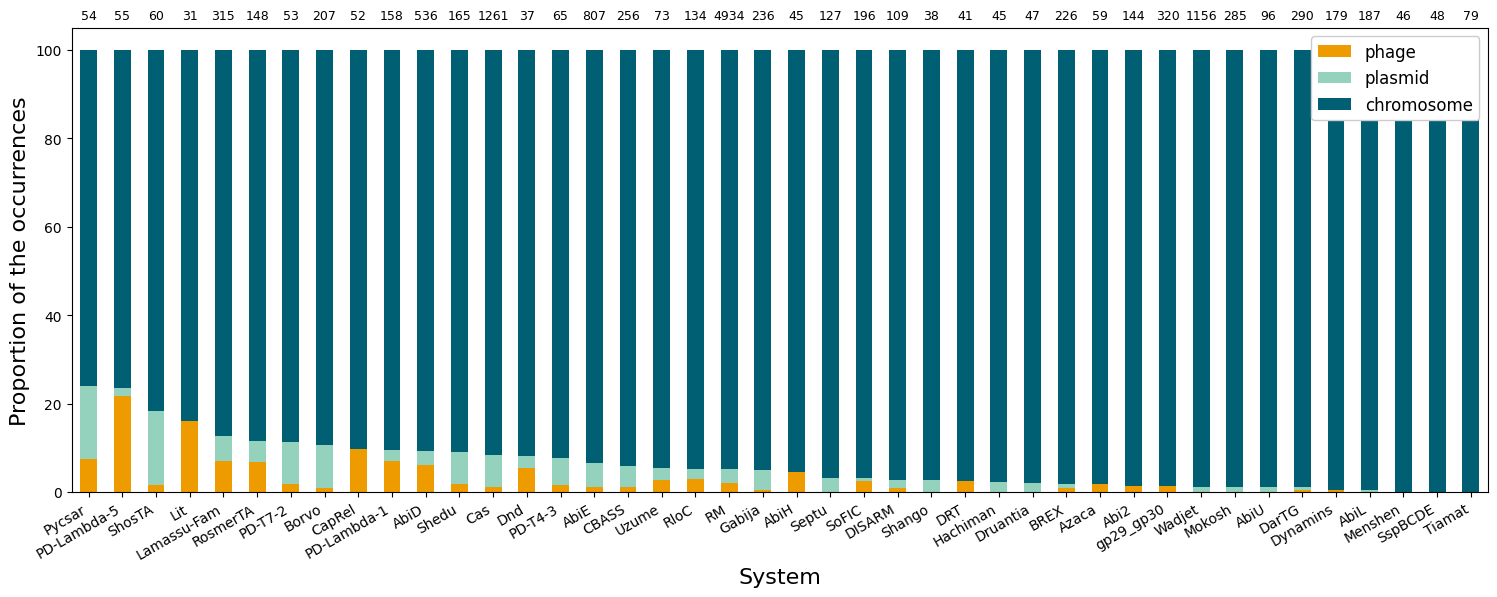

In [33]:
## Creating a table with number of occurrences depending on replicon type (Chromosome, Phage, Plasmid) by defense system
replicon_type_by_sys = df_sys.groupby(['replicon_type_corrected','System']).size().to_frame(name = 'occurrences')
replicon_type_by_sys_pivoted = replicon_type_by_sys.reset_index().pivot(index = 'System', columns = 'replicon_type_corrected', values = 'occurrences').reset_index().fillna(0)

replicon_type_by_sys_pivoted = replicon_type_by_sys_pivoted.set_index('System', drop = True)
replicon_type_by_sys_pivoted['total'] = replicon_type_by_sys_pivoted['Chromosome'] + replicon_type_by_sys_pivoted['Phage'] + replicon_type_by_sys_pivoted['Plasmid']
replicon_type_by_sys_pivoted = replicon_type_by_sys_pivoted.loc[replicon_type_by_sys_pivoted.total >= 30] # Filter to remove systems with less than 30 occurrences

## Converting the table in % of occurrences
replicon_type_by_sys_pivoted['phage'] = 100*replicon_type_by_sys_pivoted['Phage'] / replicon_type_by_sys_pivoted['total']
replicon_type_by_sys_pivoted['plasmid'] = 100*replicon_type_by_sys_pivoted['Plasmid'] / replicon_type_by_sys_pivoted['total']
replicon_type_by_sys_pivoted['chromosome'] = 100*replicon_type_by_sys_pivoted['Chromosome'] / replicon_type_by_sys_pivoted['total']

## Plot
fig,ax = plt.subplots(figsize = (15,6))
replicon_type_by_sys_pivoted[['phage', 'plasmid', 'chromosome']].sort_values(['chromosome'], ascending = True).plot(kind = 'bar', stacked = True, color = [palette1[5], palette1[3], palette1[1]], ax = ax)

## legends
legend_nb = [str((int(i))) for i in replicon_type_by_sys_pivoted.sort_values(['chromosome'])['total']]
pos = range(len(legend_nb))

for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 107, legend_nb[tick], horizontalalignment='center', size=9, color='black') #weight='semibold')
    

ax.legend(loc='upper right', fancybox=True, framealpha=1, fontsize = 'large')


plt.setp(ax.get_xticklabels(), rotation=30, ha='right', size = 10)
plt.ylabel('Proportion of the occurrences', size =16)
plt.xlabel('System',size =16)
plt.tight_layout(pad=0.8, w_pad=0.5, h_pad=1.0)

plt.show()

# Figures 4

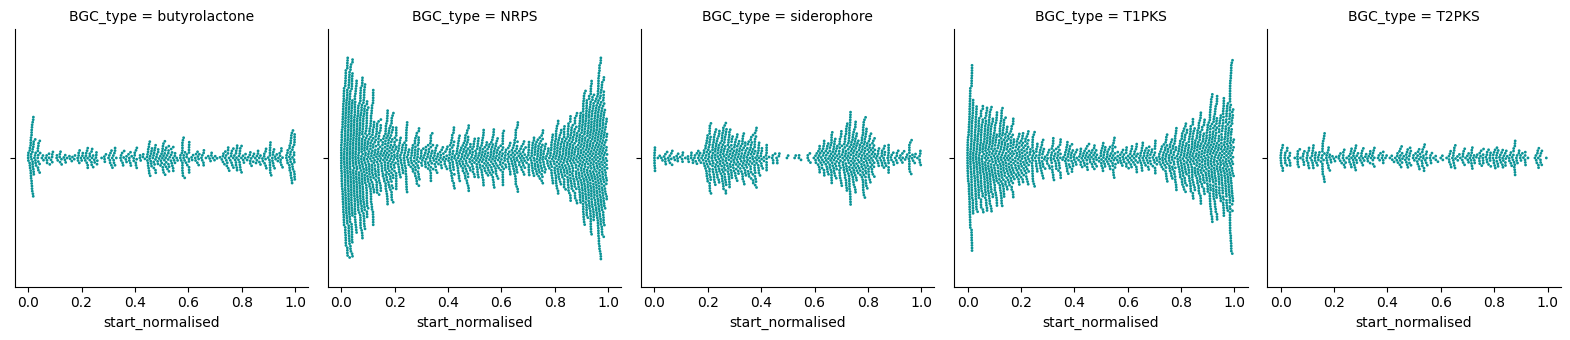

In [34]:
## archetypal examples of BGCs spatial distribution on Streptomyces linear chromosomes
data=antismash_strep_select.loc[antismash_strep_select.BGC_type.isin(['T1PKS','NRPS','siderophore','T2PKS','butyrolactone'])]
g = sns.catplot(x="start_normalised", col = 'BGC_type',
                   col_wrap = 8, data=data, height=3.5, aspect=0.9, color = palette1[2], s=2, kind = 'swarm')


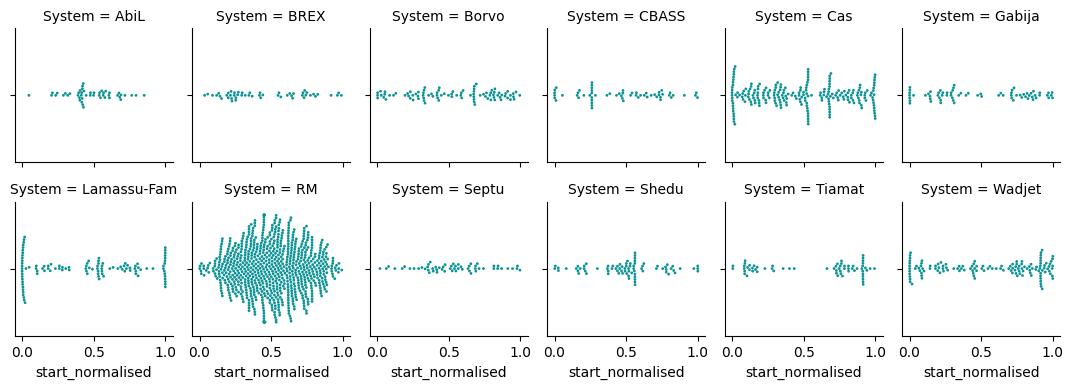

In [35]:
## Spatial distribution of defense systems on Streptomyces linear chromosomes
g = sns.catplot(x="start_normalised", col = 'System',
                   col_wrap = 6, data=df_strep_select.loc[df_strep_select.System.isin(system_ok_strep)].sort_values('System'), height=2, aspect=0.9, color = palette1[2], s=2, kind = 'swarm')


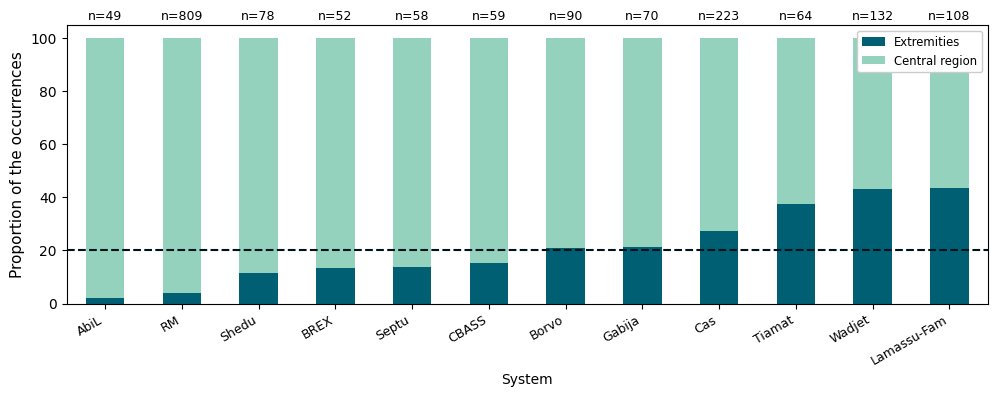

In [36]:
# Spatial distribution of defense systems on Streptomyces linear chromosomes

## Getting the number of occurrences by replicon type for each type of anti-phage system
pos_by_sys = df_strep_select.groupby(['System','position_chr']).size().to_frame(name = 'occurrences')
pos_by_sys_pivoted = pos_by_sys.reset_index().pivot(index = 'System', columns = 'position_chr', values = 'occurrences').reset_index().fillna(0)
pos_by_sys_pivoted['total'] = pos_by_sys_pivoted['extremities'] + pos_by_sys_pivoted['middle']
pos_by_sys_pivoted = pos_by_sys_pivoted.loc[pos_by_sys_pivoted.total > 45] ## filter to remove systems with less than 45 occurrences

## For each system, getting the percentage of the occurrences that occur in the extremities vs in the central region of the chromosome
pos_by_sys_pivoted['Extremities'] = 100*pos_by_sys_pivoted['extremities'] / pos_by_sys_pivoted['total']
pos_by_sys_pivoted['Central region'] = 100*pos_by_sys_pivoted['middle'] / pos_by_sys_pivoted['total']

pos_by_sys_pivoted.set_index('System', inplace = True)

## Plotting
fig,ax = plt.subplots(1,1, figsize = (10,4))
pos_by_sys_pivoted[['Extremities','Central region']].sort_values('Extremities').plot(kind = 'bar', stacked = True, color = [palette1[1], palette1[3]], ax = ax)

## Formatting the graph
ax.hlines(y = (2*limit_extrem*100), xmin = min(pos)-0.5, xmax = max(pos)+0.5, linestyles='dashed', colors=palette1[0])
ax.legend(loc='upper right', fancybox=True, framealpha=1, fontsize = 'small')

## Adding the total number of occurrences of each type of systems to the graph
legend_nb = ['n='+str((int(i))) for i in pos_by_sys_pivoted.sort_values('Extremities')['total']]
pos = range(len(legend_nb))

for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 107, legend_nb[tick], horizontalalignment='center', size=9, color='black') #weight='semibold')
    

plt.setp(ax.get_xticklabels(), rotation=30, ha='right', size = 9)
plt.ylabel('Proportion of the occurrences', size =11)
plt.tight_layout(pad=0.8, w_pad=0.5, h_pad=1.0)
plt.show()